<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/master/lesson09-rectified_reconstruction/sparse_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage, misc


#Plane Sweeping and NCC for matching

In [2]:
def plane_sweep_ncc(im_l,im_r,start,steps,wid):
    """ Find disparity image using normalized cross-correlation. """
    m,n = im_l.shape

    # arrays to hold the different sums
    mean_l = np.zeros((m,n))
    mean_r = np.zeros((m,n))
    s = np.zeros((m,n))
    s_l = np.zeros((m,n))
    s_r = np.zeros((m,n))
    # array to hold depth planes
    dmaps = np.zeros((m,n,steps))

    # compute mean of patch
    ndimage.uniform_filter(im_l,wid,mean_l)
    ndimage.uniform_filter(im_r,wid,mean_r)

    # normalized images
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # try different disparities
    for displ in range(steps):
      # move left image to the right, compute sums

      ndimage.uniform_filter(norm_l*np.roll(norm_r,displ+start),wid,s) # sum nominator
      ndimage.uniform_filter(norm_l*norm_l,wid,s_l)
      ndimage.uniform_filter(np.roll(norm_r,displ+start)*np.roll(norm_r,displ+start),wid,s_r) # sum denominator
      # store ncc scores
      dmaps[:,:,displ] = s/np.sqrt(np.absolute(s_l*s_r))


    # pick best depth for each pixel
    best_map = np.argmax(dmaps,axis=2) + start

    return best_map


def plane_sweep_gauss(im_l,im_r,start,steps,wid):
    """ Find disparity image using normalized cross-correlation
    with Gaussian weighted neigborhoods. """
    m,n = im_l.shape

    # arrays to hold the different sums
    mean_l = np.zeros((m,n))
    mean_r = np.zeros((m,n))
    s = np.zeros((m,n))
    s_l = np.zeros((m,n))
    s_r = np.zeros((m,n))

    # array to hold depth planes
    dmaps = np.zeros((m,n,steps))

    # compute mean
    ndimage.gaussian_filter(im_l,wid,0,mean_l)
    ndimage.gaussian_filter(im_r,wid,0,mean_r)

    # normalized images
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # try different disparities
    for displ in range(steps):
      # move left image to the right, compute sums
      ndimage.gaussian_filter(norm_l*np.roll(norm_r,displ+start),wid,0,s)  # sum nominator
      ndimage.gaussian_filter(norm_l*norm_l,wid,0,s_l)
      ndimage.gaussian_filter(np.roll(norm_r,displ+start)*np.roll(norm_r,displ+start),wid,0,s_r) # sum denominator

      # store ncc scores
      dmaps[:,:,displ] = s/np.sqrt(s_l*s_r)

      # pick best depth for each pixel
      best_map = np.argmax(dmaps,axis=2)+ start


    return best_map


#Main

288 384


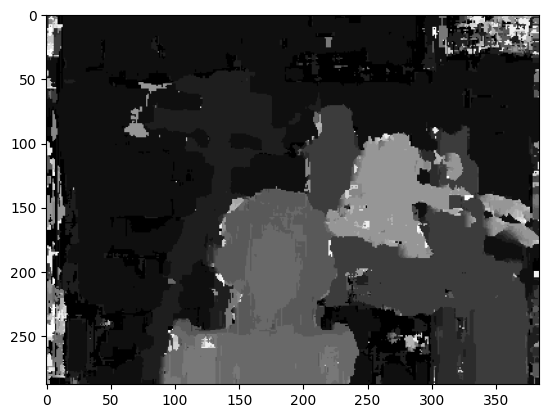

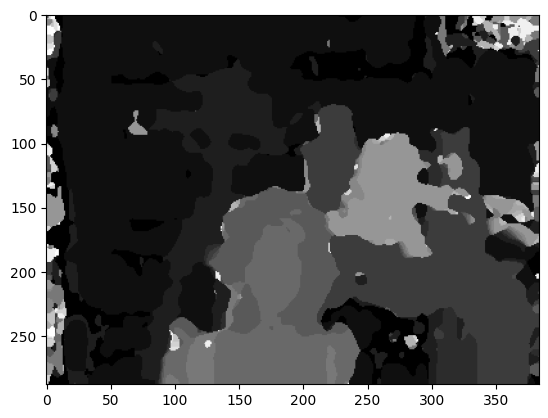

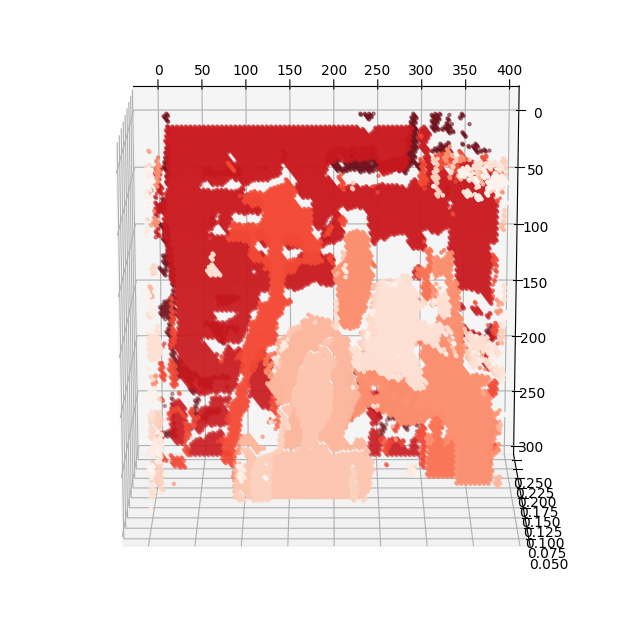

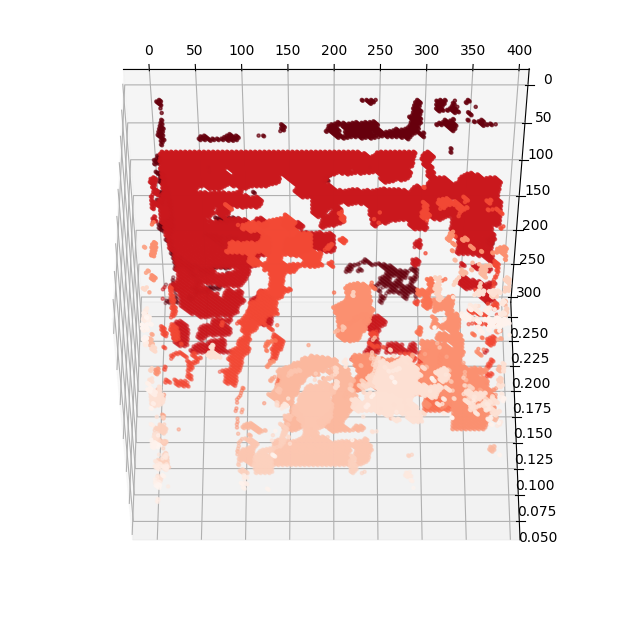

In [13]:
CASE = 1

if CASE == 1:
    im_l = np.array(Image.open('scene1.row3.col1.ppm').convert('L'),'f')
    im_r = np.array(Image.open('scene1.row3.col2.ppm').convert('L'),'f')
    # starting displacement and steps
    steps = 18
    start = 4

if CASE == 2:
    im_l = np.array(Image.open('im2.png').convert('L'),'f')
    im_r = np.array(Image.open('im6.png').convert('L'),'f')
    # starting displacement and steps
    steps = 45
    start = 12

m,n = im_l.shape
print(m,n)

# width for ncc
wid1 = 9
wid2 = 3
res1 = plane_sweep_ncc(im_l,im_r,start,steps,wid1)
res2 = plane_sweep_gauss(im_l,im_r,start,steps,wid2)

plt.figure()
plt.imshow(res1,'gray')
plt.figure()
plt.imshow(res2,'gray')


### Added by Raquel
# Calculate depth considering f.sx.b = 1 in the expression Z = f.sx.b/(xl-xr)
Z = np.zeros((m,n))
for i in range(m):
	for j in range(n):
		if (res2[i,j]== 0):
			# Consider Z = inf for points that were not defined in the depthmap and are filled with zero
			Z[i,j] = np.inf
		else: Z[i,j]=1/res2[i,j]



# Prepare points to be 3D plotted
X,Y = np.meshgrid(np.arange(n),np.arange(m))
X = np.reshape(X, m*n)
Y = np.reshape(Y, m*n)
Z = np.reshape(Z, m*n)


import math

# Select just the estimated depth
estimated = (np.isinf(Z)==False)

# Show points in a 3D plot with the recovered depth
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X[estimated][0:-1:5],Y[estimated][0:-1:5],Z[estimated][0:-1:5],c=Z[estimated][0:-1:5], cmap='Reds',marker='.')

ax.view_init(elev=-75,azim=-90)

# Show points in a 3D plot with the recovered depth
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X[estimated][0:-1:5],Y[estimated][0:-1:5],Z[estimated][0:-1:5],c=Z[estimated][0:-1:5], cmap='Reds',marker='.')

ax.view_init(elev=-35,azim=-90)


plt.show()
